### How to compare small images quickly?
we'll try to see different ways to do this :-)

In [1]:
%matplotlib inline
import time
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import platform; print platform.python_version()
print np.__version__,',', matplotlib.__version__

2.7.11
1.10.4 , 1.5.1


We'll build n = 2000 images, n1 original images, and we'll stack n2 images which are repeated

In [2]:
n = 2000
n1 = 500
n2 = 1500

In [3]:
myarr = np.random.rand(n1,28,28)
rand_idx = np.random.randint(n1, size = n2)
print rand_idx
for k in rand_idx:
    img = np.multiply(myarr[k,:,:],np.ones((1,28,28)))
    #print img.shape,myarr.shape
    myarr = np.vstack((myarr,img))
print myarr.shape

[391 128 345 ...,  33   8 285]
(2000, 28, 28)


How are the repeated images distributed?

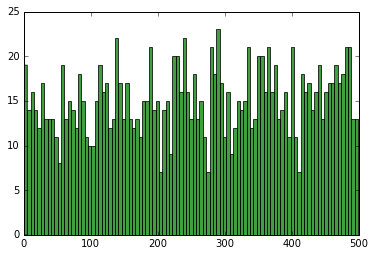

In [4]:
plt.hist(rand_idx, 99, facecolor='green', alpha=0.75);

In [5]:
myarr[285,0,:]

array([ 0.43858336,  0.25930653,  0.74588191,  0.61385863,  0.95820178,
        0.5928673 ,  0.09312251,  0.58371979,  0.43893137,  0.93119179,
        0.91885426,  0.74920376,  0.53996378,  0.21061973,  0.13609454,
        0.27677527,  0.61508461,  0.26620891,  0.97971981,  0.51001837,
        0.05156775,  0.72917068,  0.94103832,  0.87014687,  0.99404425,
        0.49612465,  0.6209528 ,  0.64787867])

In [6]:
myarr[1999,0,:]

array([ 0.43858336,  0.25930653,  0.74588191,  0.61385863,  0.95820178,
        0.5928673 ,  0.09312251,  0.58371979,  0.43893137,  0.93119179,
        0.91885426,  0.74920376,  0.53996378,  0.21061973,  0.13609454,
        0.27677527,  0.61508461,  0.26620891,  0.97971981,  0.51001837,
        0.05156775,  0.72917068,  0.94103832,  0.87014687,  0.99404425,
        0.49612465,  0.6209528 ,  0.64787867])

There is an array_equal numpy function, and we can be sure that it works with the help of np.imshow()

In [8]:
np.array_equal(myarr[285,:,:],myarr[1999,:,:])

True

Convince yourself that the following are exactly the same images :-)

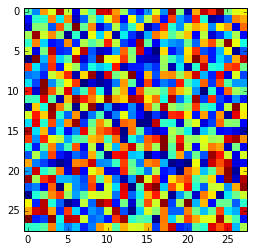

In [9]:
plt.figure()
plt.imshow(myarr[285,:,:],interpolation='nearest')

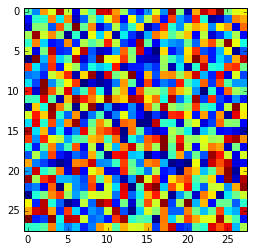

In [10]:
plt.figure()
plt.imshow(myarr[1999,:,:],interpolation='nearest')

## Now let's see the times spent:
_____

**Version 1**: built-it function

In [11]:
%%time

count = 0
for i in range(n):
    for j in range(i+1,n):
        if np.array_equal( myarr[i,:,:],myarr[j,:,:]):            
            count +=1

CPU times: user 14.8 s, sys: 36.5 ms, total: 14.8 s
Wall time: 14.9 s


In [12]:
print count

3755


**Version 2**: what about doing a first check: let's compare one pixel

In [13]:
%%time
count = 0
for i in range(n):
    for j in range(i+1,n):
        if myarr[i,0,0] ==myarr[j,0,0]:
            if np.array_equal( myarr[i,:,:],myarr[j,:,:]):
                count +=1

CPU times: user 1.18 s, sys: 6.29 ms, total: 1.19 s
Wall time: 1.19 s


In [14]:
print count

3755


**Version 3**: what if we try to compare to a zero vector?

In [15]:
%%time

count = 0
v = np.zeros((28,28))
for i in range(n):
    for j in range(i+1,n):
           if np.array_equal(myarr[i,:,:]-myarr[j,:,:], v):
                count +=1

CPU times: user 17.6 s, sys: 38.7 ms, total: 17.6 s
Wall time: 17.7 s


In [16]:
print count

3755


**Version 4: **
    what if we try to compare vectorized versions of the vector?

In [17]:
%%time
count = 0
v = np.zeros((28,28))
for i in range(n):
    for j in range(i+1,n):
           if np.array_equal(myarr[i,:,:].ravel(),myarr[j,:,:].ravel()):
                count +=1

CPU times: user 13.9 s, sys: 19.7 ms, total: 13.9 s
Wall time: 13.9 s


In [18]:
print count

3755


**version 5:** if we select the python built-in version that checks for floating point errors, it's waaaayy longer

In [19]:
%%time
count = 0
v = np.zeros((28,28))
for i in range(n):
    for j in range(i+1,n):
           if np.allclose(myarr[i,:,:],myarr[j,:,:]):
                count +=1

CPU times: user 1min 20s, sys: 136 ms, total: 1min 20s
Wall time: 1min 20s


In [20]:
print count

3755


________
Now we try to build the array_equal function *from scratch*,  by checking the pixels one by one

In [21]:
def compare_line(n,myarr1,myarr2):
    for k in xrange(n):
        if not myarr1[k]==myarr2[k]:
            return False
    return True   
    
def compare_img(m,n,img1,img2):
    for k in xrange(m):
        if not compare_line(n,img1[k,:],img2[k,:]):
            return False
    return True    


Let's see if it works on basic arrays

In [22]:
compare_img(5,5,np.zeros((5,5)), np.ones((5,5)))

False

In [23]:
compare_img(10,10,np.zeros((10,10)),np.zeros((10,10)))

True

cool!
...

**version 6**: Let it run

In [24]:
%%time
count = 0

for i in range(n):
    for j in range(i+1,n):
        if compare_img(28,28,myarr[i,:,:],myarr[j,:,:]):
            count +=1

CPU times: user 5.78 s, sys: 20 ms, total: 5.8 s
Wall time: 5.8 s


In [25]:
print count

3755


**version 7:**
    what if we both  vectorize and compare the pixels one at a time?

In [26]:
%%time
count = 0

for i in range(n):
    for j in range(i+1,n):
        if compare_line(784,myarr[i,:,:].ravel(),myarr[j,:,:].ravel()):
            count +=1

CPU times: user 4.8 s, sys: 35 ms, total: 4.84 s
Wall time: 4.82 s


In [27]:
print count

3755
